# PRÁCTICA 6: REDES GENERATIVAS ANTAGÓNICAS (GAN)

En esta práctica vamos a definir ina red generativa antagónica (__GAN__), siendo esta arquitectura muy popular graicas a su capacidad mejorada de generación de datos en comparación a otras arquitecturas más clásicas como los __Autoencoder__.

Este tipo de redes son además un muy buen ejemplo para aprender a trabajar con diferentes optimizadores y pasos de backpropagation, lo que nos permite tener un mayor control de como se actualizan y comportan diferentes partes de nuestra red.

Vamos a comenzar importando las librerías que necesitaremos durante la práctica:

In [ ]:
!jupyter nbextension enable --py widgetsnbextension

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [ ]:
import os
import uuid

# Librerías de PyTorch
import torch
from torch import nn

# Torch vision para descargar y preprocesar el conjunto de datos que usaremos para entrenar la red
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets

# Herramientas adicionales para la visualización de los datos y resultados
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

Como hemos hecho en otras prácticas, vamos a continuar definiendo una seria de variables para configurar parte de los hiperparámetros de la red:

In [ ]:
NUM_EPOCHS = 50
NOISE_DIMENSION = 50
BATCH_SIZE = 128
TRAIN_ON_GPU = True
UNIQUE_RUN_ID = str(uuid.uuid4())
PRINT_STATS_AFTER_BATCH = 50
OPTIMIZER_LR = 0.0002
OPTIMIZER_BETAS = (0.5, 0.999)
GENERATOR_OUTPUT_IMAGE_SHAPE = 28 * 28 * 1

También vamos a aprovehcar a configurar __PyTorch__ con el objetivo de mejorar la velocidad de ejecución de nuestra red:

In [ ]:
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.backends.cudnn.benchmark = True

Durante esta práctica usaremos de nuevo el conjunto de datos `FashionMNIST` para entrenar la red. Comenzaremos por descargar y generar el `DataLoader` para poder enviar datos a la red de manera eficiente:

In [ ]:
train_dataset = datasets.FashionMNIST("./MNIST_DATA", train=True, download=True,transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=4)

También podemos aprovechar para visualizar los datos como hemos hecho en prácticas anteriores:

Inspección de los datos de entrenamiento: 
Tamaño del lote:  torch.Size([64, 1, 28, 28])


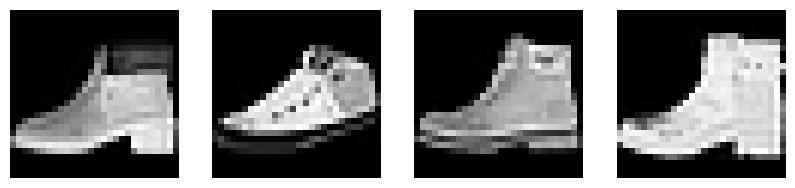

In [ ]:
print("Inspección de los datos de entrenamiento: ")
for _, data in enumerate(train_loader):
    print("Tamaño del lote: ", data[0].shape)
    fig, ax = plt.subplots(1, 4, figsize=(10, 4))

    for i in range(4):
        ax[i].imshow(data[0][i].squeeze(), cmap="gray")
        ax[i].axis("off")
    plt.show()
    # Hacemos break para no recorrer todo el loader
    break

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*8F2BDwhBH4DdYhx5e7u04A.jpeg">

Las redes __GAN__ están formadas por dos redes neuronales diferentes:
- **Generador**: Tiene como objetivo aprender a generar datos a partir de una entrada "fija" (en nuestro caso, una imagen de ruido)
- **Discriminador**: Esta red tiene como objetivo aprender a discriminar sin una imgen es real o falsa (es decir, generada por el **Generador**).

El proceso de entrenamiento de este tipo de redes se puede comparar con el de un falsificador y un policía. El **Generador** actúa como el falsificador, mientras que la tarea de la policía es atraparlo. Cuando la policía detecta más imágenes falsificadas, el falsificador debe aprender a producir mejores resultados. Esto es exactamente lo que sucede: a medida que el **Discriminador** mejora su capacidad para discernir si una imagen es falsa o real, el **Generador** finalmente mejora su capacidad para generar imágenes falsas. En consecuencia, el **Generador** puede utilizarse de forma independiente para generar imágenes después de su entrenamiento.

Vamos a comenzar definiendo nuestro **Generador**:

In [ ]:
class Generator(nn.Module):
  def __init__(self,):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(NOISE_DIMENSION, 128),
      nn.BatchNorm1d(128, 0.8),
      nn.LeakyReLU(0.25),
      nn.Linear(128, 256),
      nn.BatchNorm1d(256, 0.8),
      nn.LeakyReLU(0.25),
      nn.Linear(256, 512),
      nn.BatchNorm1d(512, 0.8),
      nn.LeakyReLU(0.25),
      nn.Linear(512, GENERATOR_OUTPUT_IMAGE_SHAPE),
      nn.Tanh()
    )

  def forward(self, x):
    return self.layers(x)

Y continuamos con la definición del **Discriminador**:

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(GENERATOR_OUTPUT_IMAGE_SHAPE, 1024),
      nn.LeakyReLU(0.25),
      nn.Linear(1024, 512),
      nn.LeakyReLU(0.25),
      nn.Linear(512, 256),
      nn.LeakyReLU(0.25),
      nn.Linear(256, 1),
      nn.Sigmoid()
    )

  def forward(self, x):
    return self.layers(x)

Antes de entranar nuestras dos redes, vamos a definir una serie de funciones que serán útiles durante el entrenamiento y la evaluación de los resultados de las dos redes:

In [ ]:
def get_device():
  return torch.device("cuda:0" if torch.cuda.is_available() and TRAIN_ON_GPU else "cpu")

def make_directory_for_run():
  """ Vamos a guardar los resultados de cada ejecución en una carpeta diferente """
  print(f'Preparando la ejecución {UNIQUE_RUN_ID}')
  if not os.path.exists('./runs'):
    os.mkdir('./runs')
  os.mkdir(f'./runs/{UNIQUE_RUN_ID}')

def generate_noise(number_of_images=1, noise_dimension=NOISE_DIMENSION, device=None):
  return torch.randn(number_of_images, noise_dimension, device=device)

def generate_image(generator, epoch=0, batch=0, device=get_device()):
  images = []
  noise = generate_noise(BATCH_SIZE, device=device)

  with torch.no_grad():
    images = generator(noise)

  plt.figure(figsize=(10, 10))
  for i in range(16):
    image = images[i]

    image = image.cpu().numpy()
    image = np.reshape(image, (28, 28))

    plt.subplot(4, 4, i + 1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
  if not os.path.exists(f'./runs/{UNIQUE_RUN_ID}/images'):
    os.mkdir(f'./runs/{UNIQUE_RUN_ID}/images')
  plt.savefig(f'./runs/{UNIQUE_RUN_ID}/images/epoch{epoch}_batch{batch}.jpg')
  plt.close()

def save_models(generator, discriminator, epoch):
  """ Save models at specific point in time. """
  torch.save(generator.state_dict(), f'./runs/{UNIQUE_RUN_ID}/generator_{epoch}.pth')
  torch.save(discriminator.state_dict(), f'./runs/{UNIQUE_RUN_ID}/discriminator_{epoch}.pth')

Continuamos con una seria de funciones de inicialización, encargadas de inicializar nuestras redes, funciones de péridida y los optimizadores que se usaran para actualizar los parámetros de cada red de manera independiente:

In [ ]:
def initialize_models(device=get_device()):
  generator = Generator()
  discriminator = Discriminator()
  generator.to(device)
  discriminator.to(device)
  return generator, discriminator

def initialize_optimizers(generator, discriminator):
  generator_optimizer = torch.optim.AdamW(generator.parameters(), lr=OPTIMIZER_LR,betas=OPTIMIZER_BETAS)
  discriminator_optimizer = torch.optim.AdamW(discriminator.parameters(), lr=OPTIMIZER_LR,betas=OPTIMIZER_BETAS)
  return generator_optimizer, discriminator_optimizer

Por último, vamos a definir una función adicional para anular nuestros gradientes.

Esta función tiene un efecto similar a ``optimizer-zero_grad()`` pero es más eficiente. En la mayoría de casos, podemos usar esta nueva función para mejorar la velocidad de entrenamiento sin afectar a la precisión de los resultados obtenidos (aunque es importante mencionar que la estabilidad númerica de estas dos funciones es diferentes y se pueden producir pequeñas desviaciones numéricas en los parámetros de la red al usar una u otra).

In [ ]:
def efficient_zero_grad(model):

  for param in model.parameters():
    param.grad = None

Por último definimos nuestro loop de entrenamiento:

In [ ]:
def train(generator, discriminator):
    # Optimizadores
    opt_generator, opt_discriminator = initialize_optimizers(generator, discriminator)

    # Dataloader
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=4)

    # Función de pérdida
    loss_fn = nn.BCELoss()

    device = get_device()
    make_directory_for_run()

    for epoch in range(NUM_EPOCHS):
        # Barra de progreso
        bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc=f"Train epoch {epoch}")

        train_loss_disc = 0.0
        train_loss_gen = 0.0

        for i, (x, _) in enumerate(train_loader):
            real_label, fake_label = 1.0, 0.0

            real_images = x.to(device)
            label = torch.full((BATCH_SIZE, 1), real_label, device=device)

            # PASO 1: Entrenamiento del discriminador
            efficient_zero_grad(discriminator)

            # Imágenes reales
            real_images = real_images.view(real_images.size(0), -1)
            y = discriminator(real_images)
            loss_disc_real = loss_fn(y, label)
            loss_disc_real.backward()

            # Imágenes falsas
            noise = generate_noise(BATCH_SIZE, device=device)
            generated_images = generator(noise)
            label.fill_(fake_label)
            y = discriminator(generated_images.detach())  # Como aquí no entrenamos el generador, tenemos que usar detach() para que PyTorch no tenga en cuenta su gradiente
            loss_disc_fake = loss_fn(y, label)
            loss_disc_fake.backward()

            opt_discriminator.step()

            ########################################

            # PASO 2: Entrenamiento del generador
            efficient_zero_grad(generator)
            label.fill_(real_label)
            y = discriminator(generated_images)  # Como aquí sí entrenamos el generador, no usamos detach()
            loss_gen = loss_fn(y, label)
            loss_gen.backward()
            opt_generator.step()

            #####################################

            # Pérdidas finales
            loss_disc = loss_disc_real + loss_disc_fake

            train_loss_disc += loss_disc.item()
            train_loss_gen += loss_gen.item()

            bar.set_postfix(
            loss_disc=f"{train_loss_disc/(i+1):.4f}",
            loss_gen=f"{train_loss_gen/(i+1):.4f}",
            )
            bar.update()

        bar.close()

        # Guardamos los modelos para cada epoch (checkpointing)
        save_models(generator, discriminator, epoch)

        # Guardamos las imágenes del generador
        generate_image(generator, epoch=epoch, batch=i)

        # Liberamos la memoria tras cada epoch
        torch.cuda.empty_cache()

Por último, entrenamos nuestros modelos:

In [ ]:
generator, discriminator = initialize_models()
train(generator, discriminator)

Preparando la ejecución d7441c09-da17-4cd0-9c08-c6975f1cd905


Imágenes generador en la primera epoch:

<img src="https://github.com/rgutierrezs/Curso_Practico_Deep_Learning/blob/main/runs/d7441c09-da17-4cd0-9c08-c6975f1cd905/images/epoch0_batch467.jpg?raw=1" width=500 />

Imágenes generador en la última epoch:

<img src="https://github.com/rgutierrezs/Curso_Practico_Deep_Learning/blob/main/runs/d7441c09-da17-4cd0-9c08-c6975f1cd905/images/epoch49_batch467.jpg?raw=1" width=500 />